In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
try:
    df = pd.read_csv('data/Mall_Customers.csv')
except FileNotFoundError:
    print("Error: mall_customers.csv not found. Please ensure it's in the 'data' directory.")
    # Create a dummy dataframe for demonstration if file is not found
    data = {'CustomerID': range(1, 11),
            'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
            'Age': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
            'Annual Income (k$)': [15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
            'Spending Score (1-100)': [39, 81, 6, 77, 40, 76, 6, 72, 10, 65]}
    df = pd.DataFrame(data)
    df.to_csv('../data/mall_customers.csv', index=False)
    print("Created a dummy mall_customers.csv for testing.")

df.rename(columns={'Annual Income (k$)': 'Annual Income', 'Spending Score (1-100)': 'Spending Score'}, inplace=True)
df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Preprocessing Pipeline
numerical_features = ['Age', 'Annual Income', 'Spending Score']
categorical_features = ['Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X = df.drop('CustomerID', axis=1)

In [4]:
# Fit preprocessor and transform data
X_processed = preprocessor.fit_transform(X)

In [6]:
# Save the preprocessor
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

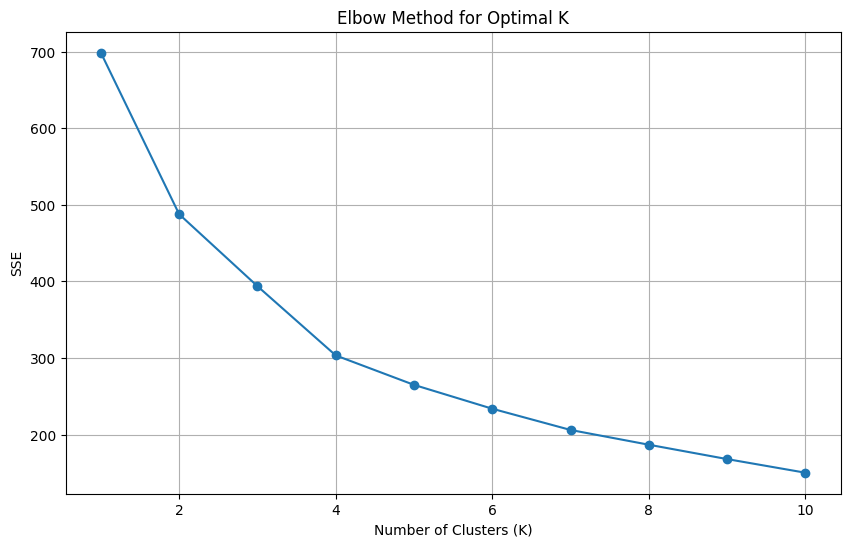

In [7]:
# Determine optimal K for K-Means using Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.grid(True)
plt.savefig('models/elbow_method.png')
plt.show()

In [9]:
# Model Training and Evaluation
# Using K=5 based on typical elbow method observation for this dataset
n_clusters = 5

models = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5), # Parameters need tuning based on data
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}

results = {}
fitted_models = {}

for name, model in models.items():
    if name == 'DBSCAN':
        # DBSCAN can result in -1 for noise points, which affects score calculation
        clusters = model.fit_predict(X_processed)
        # Filter out noise points for evaluation
        X_filtered = X_processed[clusters != -1]
        clusters_filtered = clusters[clusters != -1]
        if len(np.unique(clusters_filtered)) > 1:
            silhouette = silhouette_score(X_filtered, clusters_filtered)
            davies_bouldin = davies_bouldin_score(X_filtered, clusters_filtered)
            calinski_harabasz = calinski_harabasz_score(X_filtered, clusters_filtered)
        else:
            silhouette, davies_bouldin, calinski_harabasz = np.nan, np.nan, np.nan # Not enough clusters for scoring
    else:
        model.fit(X_processed)
        clusters = model.predict(X_processed) if hasattr(model, 'predict') else model.labels_
        silhouette = silhouette_score(X_processed, clusters)
        davies_bouldin = davies_bouldin_score(X_processed, clusters)
        calinski_harabasz = calinski_harabasz_score(X_processed, clusters)
    
    results[name] = {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
    }
    fitted_models[name] = model
    
    # Save the fitted model
    with open(f'models/{name.lower()}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [10]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                         Silhouette Score  Davies-Bouldin Index  \
KMeans                           0.315256              1.153338   
AgglomerativeClustering          0.314824              1.194445   
DBSCAN                           0.508364              0.684079   
GaussianMixture                  0.022402              1.394532   

                         Calinski-Harabasz Score  
KMeans                                 79.851848  
AgglomerativeClustering                75.505278  
DBSCAN                                 95.411385  
GaussianMixture                        15.753936  


In [12]:
# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Save PCA model
with open('models/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

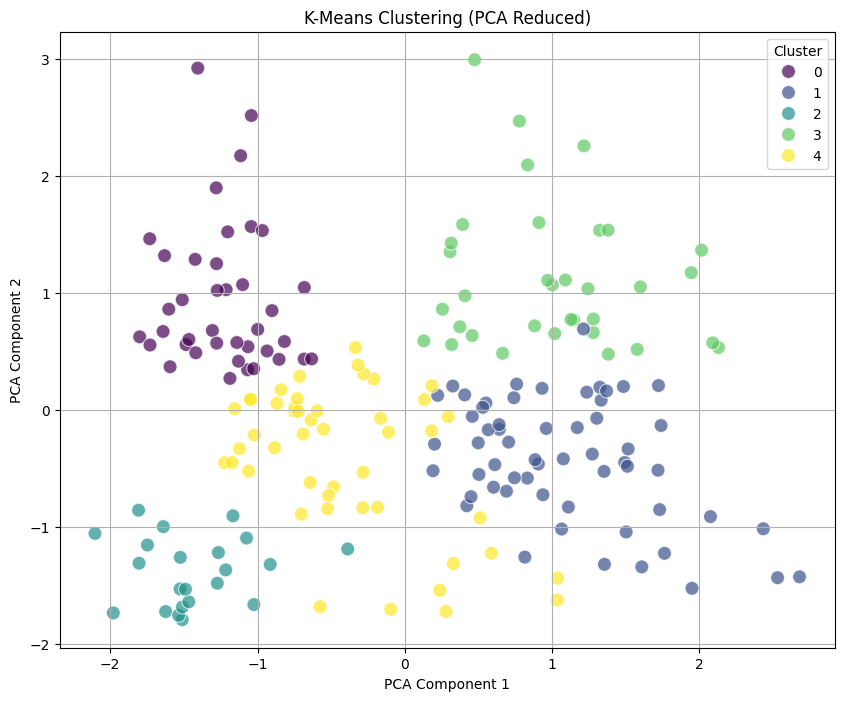

In [13]:
# Visualize Clusters (Example with KMeans)
kmeans_model = fitted_models['KMeans']
df['Cluster'] = kmeans_model.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('models/kmeans_pca_clusters.png')
plt.show()

In [14]:
# Analyze Cluster Characteristics (Example with KMeans)
cluster_means = df.groupby('Cluster')[numerical_features].mean()
print("K-Means Cluster Means:")
print(cluster_means)

K-Means Cluster Means:
               Age  Annual Income  Spending Score
Cluster                                          
0        32.692308      86.538462       82.128205
1        55.551724      48.482759       41.775862
2        25.272727      25.727273       79.363636
3        41.264706      88.500000       16.764706
4        27.957447      50.000000       44.638298
